<div >
<img src = "banner.jpg" />
</div>

# Ridge and Lasso Basics

## Data: House Prices



We will predict house prices using the data set `matchdata` included in the `McSpatial package` for `R` to illustrate the different strategies' usage. The data contains 3204 sales of single-family homes on the Far North Side of Chicago in 1995 and 2005.

<div>
<img src="chicago.png" width="250"/>
</div>

This data set includes 18 variables/features about the home, including the price the house was sold, the number of bathrooms and bedrooms, the latitude, and longitude, etc.

Let's load the packages and the data set:

In [7]:
#packages
require("pacman")
p_load("tidyverse","stargazer")

load(url("https://github.com/ignaciomsarmiento/datasets/blob/main/matchdata.rda?raw=true"))

Stargazer can easily provide us a table with descriptive statistics:

In [8]:
stargazer(matchdata, header=FALSE, type='text',title="Variables Included in the Matched Data Set")


Variables Included in the Matched Data Set
Statistic   N     Mean    St. Dev.   Min     Max  
--------------------------------------------------
year      3,204 2,000.000  5.001    1,995   2,005 
lnland    3,204   8.309    0.380    6.633  10.076 
lnbldg    3,204   7.182    0.289    6.148   8.356 
rooms     3,204   5.792    1.230      2      12   
bedrooms  3,204   3.026    0.740      1       7   
bathrooms 3,204   1.419    0.514    1.000   5.000 
centair   3,204   0.346    0.476      0       1   
fireplace 3,204   0.160    0.367      0       1   
brick     3,204   0.668    0.471      0       1   
garage1   3,204   0.307    0.462      0       1   
garage2   3,204   0.451    0.498      0       1   
dcbd      3,204   9.694    1.729    5.245  13.602 
rr        3,204   0.160    0.367      0       1   
yrbuilt   3,204 1,934.830  21.726   1,868   1,991 
latitude  3,204  41.988    0.015   41.956  42.022 
longitude 3,204  -87.744   0.050   -87.834 -87.647
lnprice   3,204  12.410    0.526   10.

Note that the variable price is in logs. We are going to transform it back to levels:

In [9]:
matchdata <- matchdata %>% 
                      mutate(price=exp(lnprice) #transforms log prices to standard prices
                             ) 

## Ridge

In [10]:
p_load("glmnet")
y<-matchdata$price
X<-model.matrix(~rooms+bedrooms+bathrooms-1,matchdata)
head(X)

,rooms,bedrooms,bathrooms
1,5,3,1.0
2,5,3,1.5
3,5,3,1.5
4,4,2,1.0
5,6,3,1.0
6,7,3,2.0


In [11]:
grid=10^seq(10,-2,length=100)
grid

[1] 1.000000e+10 7.564633e+09 5.722368e+09 4.328761e+09 3.274549e+09
  [6] 2.477076e+09 1.873817e+09 1.417474e+09 1.072267e+09 8.111308e+08
 [11] 6.135907e+08 4.641589e+08 3.511192e+08 2.656088e+08 2.009233e+08
 [16] 1.519911e+08 1.149757e+08 8.697490e+07 6.579332e+07 4.977024e+07
 [21] 3.764936e+07 2.848036e+07 2.154435e+07 1.629751e+07 1.232847e+07
 [26] 9.326033e+06 7.054802e+06 5.336699e+06 4.037017e+06 3.053856e+06
 [31] 2.310130e+06 1.747528e+06 1.321941e+06 1.000000e+06 7.564633e+05
 [36] 5.722368e+05 4.328761e+05 3.274549e+05 2.477076e+05 1.873817e+05
 [41] 1.417474e+05 1.072267e+05 8.111308e+04 6.135907e+04 4.641589e+04
 [46] 3.511192e+04 2.656088e+04 2.009233e+04 1.519911e+04 1.149757e+04
 [51] 8.697490e+03 6.579332e+03 4.977024e+03 3.764936e+03 2.848036e+03
 [56] 2.154435e+03 1.629751e+03 1.232847e+03 9.326033e+02 7.054802e+02
 [61] 5.336699e+02 4.037017e+02 3.053856e+02 2.310130e+02 1.747528e+02
 [66] 1.321941e+02 1.000000e+02 7.564633e+01 5.722368e+01 4.328761e+01
 [71] 3.274549e+01 2.477076e+01 1.873817e+01 1.417474e+01 1.072267e+01
 [76] 8.111308e+00 6.135907e+00 4.641589e+00 3.511192e+00 2.656088e+00
 [81] 2.009233e+00 1.519911e+00 1.149757e+00 8.697490e-01 6.579332e-01
 [86] 4.977024e-01 3.764936e-01 2.848036e-01 2.154435e-01 1.629751e-01
 [91] 1.232847e-01 9.326033e-02 7.054802e-02 5.336699e-02 4.037017e-02
 [96] 3.053856e-02 2.310130e-02 1.747528e-02 1.321941e-02 1.000000e-02

In [14]:

ridge1<-glmnet(x=X,
               y=y,
               alpha=0, #0 is ridge, 1 is lasso
               lambda=grid)
coef(ridge1)

   [[ suppressing 100 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



4 x 100 sparse Matrix of class "dgCMatrix"
                                                                            
(Intercept) 2.806393e+05 2.806382e+05 2.806367e+05 2.806348e+05 2.806322e+05
rooms       2.692268e-01 3.558943e-01 4.704658e-01 6.219184e-01 8.221227e-01
bedrooms    2.981507e-01 3.941285e-01 5.210055e-01 6.887225e-01 9.104226e-01
bathrooms   7.079261e-01 9.358284e-01 1.237096e+00 1.635342e+00 2.161782e+00
                                                                            
(Intercept) 2.806288e+05 2.806243e+05 2.806183e+05 2.806104e+05 2.806000e+05
rooms       1.086768e+00 1.436592e+00 1.899001e+00 2.510210e+00 3.318076e+00
bedrooms    1.203476e+00 1.590839e+00 2.102845e+00 2.779576e+00 3.673979e+00
bathrooms   2.857671e+00 3.777538e+00 4.993447e+00 6.600630e+00 8.724924e+00
                                                                            
(Intercept) 2.805863e+05 2.805681e+05 2.805441e+05 280512.41520 280470.51785
rooms       4.385822e+00 5.796962

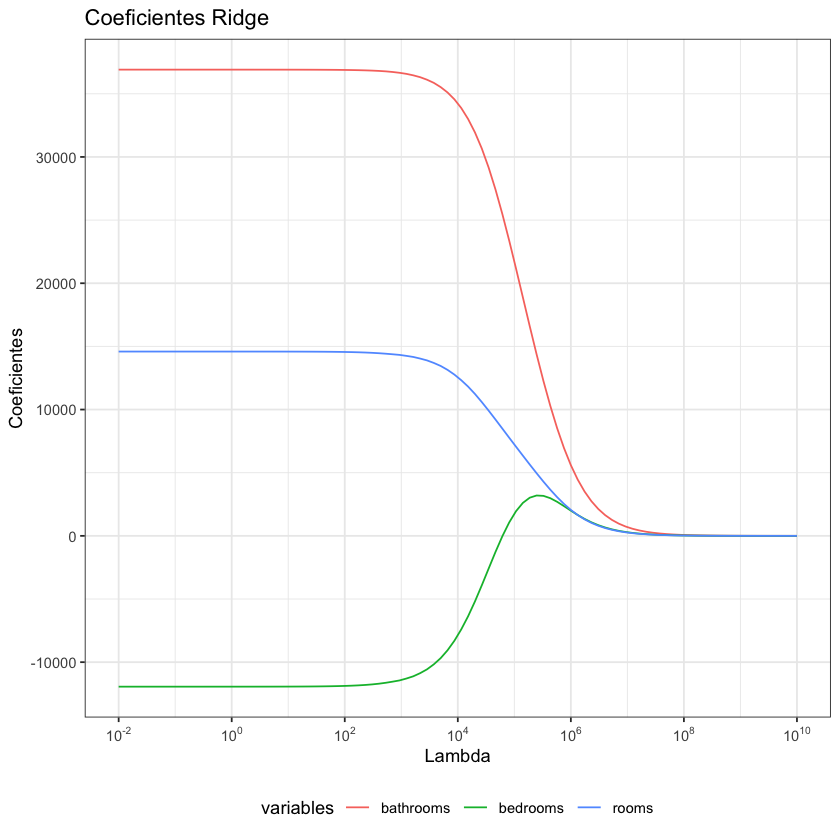

In [15]:
#Put coefficients in a data frame, except the intercept
coefs_ridge<-data.frame(t(as.matrix(coef(ridge1)))) %>% select(-X.Intercept.)
#add the lambda grid to to data frame
coefs_ridge<- coefs_ridge %>% mutate(lambda=grid)              

#ggplot friendly format
coefs_ridge<- coefs_ridge %>% pivot_longer(cols=!lambda,
                                          names_to="variables",
                                          values_to="coefficients")



ggplot(data=coefs_ridge, aes(x = lambda, y = coefficients, color = variables)) +
  geom_line() +
  scale_x_log10(
    breaks = scales::trans_breaks("log10", function(x) 10^x),
    labels = scales::trans_format("log10",
                                  scales::math_format(10^.x))
  ) +
  labs(title = "Coeficientes Ridge", x = "Lambda", y = "Coeficientes") +
  theme_bw() +
  theme(legend.position="bottom")

## Lasso

In [16]:
#Same grid
grid=10^seq(10,-2,length=100)

lasso1<-glmnet(x=X,
               y=y,
               alpha=1, #0 is ridge, 1 is lasso
               lambda=grid)

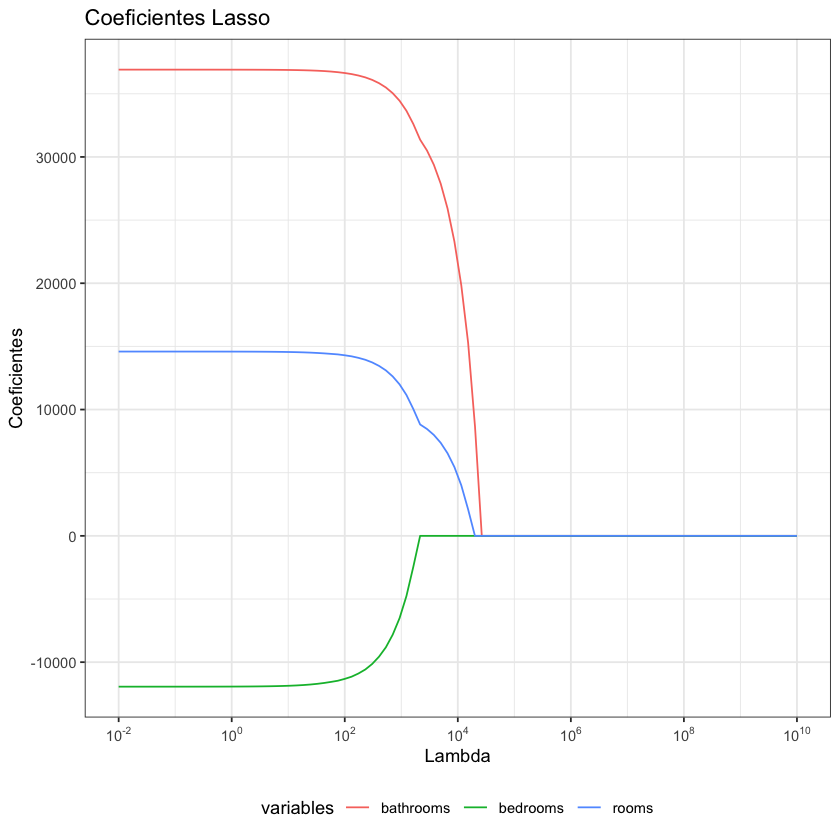

In [17]:
#Put coefficients in a data frame, except the intercept
coefs_lasso<-data.frame(t(as.matrix(coef(lasso1)))) %>% select(-X.Intercept.)
#add the lambda grid to to data frame
coefs_lasso<- coefs_lasso %>% mutate(lambda=grid)              

#ggplot friendly format
coefs_lasso<- coefs_lasso %>% pivot_longer(cols=!lambda,
                                          names_to="variables",
                                          values_to="coefficients")



ggplot(data=coefs_lasso, aes(x = lambda, y = coefficients, color = variables)) +
  geom_line() +
  scale_x_log10(
    breaks = scales::trans_breaks("log10", function(x) 10^x),
    labels = scales::trans_format("log10",
                                  scales::math_format(10^.x))
  ) +
  labs(title = "Coeficientes Lasso", x = "Lambda", y = "Coeficientes") +
  theme_bw() +
  theme(legend.position="bottom")

# Choosing the penalty parameter for out of sample performance

## Benchmark: OLS

In [18]:
p_load("caret")

set.seed(123)
fitControl <- trainControl(## 5-fold CV, 10 better
                           method = "cv",
                           number = 5)


fmla<-formula(lnprice~rooms*bedrooms*bathrooms+lnland*lnbldg*poly(dcbd,3,raw=TRUE))
linear_reg<-train(fmla,
                  data=matchdata,
                  method = 'lm', 
                  trControl = fitControl,
                  preProcess = c("center", "scale")
) 


linear_reg

Linear Regression 

3204 samples
   6 predictor

Pre-processing: centered (22), scaled (22) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2562, 2564, 2561, 2564, 2565 
Resampling results:

  RMSE       Rsquared    MAE      
  0.5063296  0.07642105  0.4553271

Tuning parameter 'intercept' was held constant at a value of TRUE

In [19]:
summary(linear_reg)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.28943 -0.44130  0.00189  0.43656  1.38562 

Coefficients:
                                             Estimate Std. Error  t value
(Intercept)                                 1.241e+01  8.887e-03 1396.393
rooms                                       8.942e-02  9.539e-02    0.937
bedrooms                                   -2.534e-02  1.010e-01   -0.251
bathrooms                                  -7.195e-03  1.663e-01   -0.043
lnland                                     -7.147e+01  2.661e+01   -2.686
lnbldg                                     -6.034e+01  2.320e+01   -2.601
`poly(dcbd, 3, raw = TRUE)1`               -8.678e+02  3.414e+02   -2.542
`poly(dcbd, 3, raw = TRUE)2`                1.769e+03  7.366e+02    2.401
`poly(dcbd, 3, raw = TRUE)3`               -9.089e+02  4.020e+02   -2.261
`rooms:bedrooms`                           -1.470e-01  1.710e-01   -0.860
`rooms:bathrooms`    

## Ridge

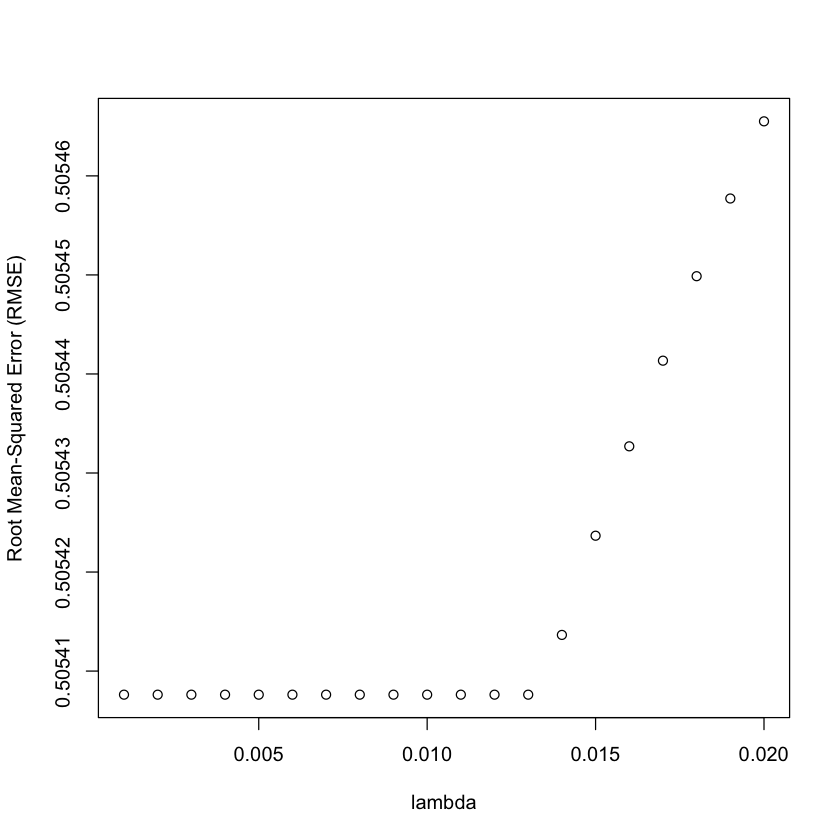

In [20]:
ridge<-train(fmla,
             data=matchdata,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha = 0, #Ridge
                                    lambda = seq(0.001,0.02,by = 0.001)),
             preProcess = c("center", "scale")
              ) 

plot(ridge$results$lambda,
     ridge$results$RMSE,
     xlab="lambda",
     ylab="Root Mean-Squared Error (RMSE)"
     )

In [21]:
ridge$bestTune

,alpha,lambda
,<dbl>,<dbl>
13,0,0.013


In [22]:
coef_ridge<-coef(ridge$finalModel, ridge$bestTune$lambda)
coef_ridge

23 x 1 sparse Matrix of class "dgCMatrix"
                                                    s1
(Intercept)                              12.4095133635
rooms                                     0.0234451563
bedrooms                                 -0.0359727050
bathrooms                                 0.0301957876
lnland                                    0.0692314351
lnbldg                                    0.0529141779
poly(dcbd, 3, raw = TRUE)1               -0.0137447162
poly(dcbd, 3, raw = TRUE)2                0.0172925620
poly(dcbd, 3, raw = TRUE)3                0.0298225371
rooms:bedrooms                           -0.0447940022
rooms:bathrooms                           0.0221793558
bedrooms:bathrooms                        0.0211339341
lnland:lnbldg                             0.0546767818
lnland:poly(dcbd, 3, raw = TRUE)1         0.0008511656
lnland:poly(dcbd, 3, raw = TRUE)2         0.0204239011
lnland:poly(dcbd, 3, raw = TRUE)3         0.0287269405
lnbldg:poly(dcbd, 3, ra

## Lasso

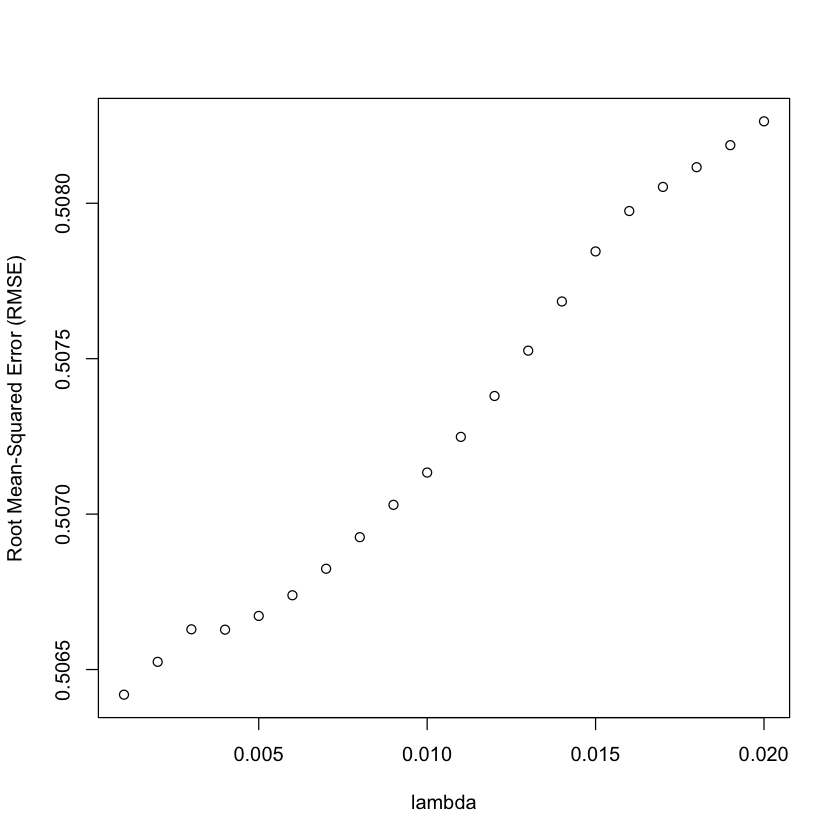

In [23]:
lasso<-train(fmla,
             data=matchdata,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha = 1, #lasso
                                    lambda = seq(0.001,0.02,by = 0.001)),
             preProcess = c("center", "scale")
              ) 

plot(lasso$results$lambda,
     lasso$results$RMSE,
     xlab="lambda",
     ylab="Root Mean-Squared Error (RMSE)"
     )

In [24]:
lasso$bestTune

,alpha,lambda
,<dbl>,<dbl>
1,1,0.001


In [25]:
coef_lasso<-coef(lasso$finalModel, lasso$bestTune$lambda)
coef_lasso

23 x 1 sparse Matrix of class "dgCMatrix"
                                                   s1
(Intercept)                              12.409513363
rooms                                     0.016274762
bedrooms                                 -0.038741482
bathrooms                                 0.050587825
lnland                                    0.101781507
lnbldg                                    0.087561820
poly(dcbd, 3, raw = TRUE)1                .          
poly(dcbd, 3, raw = TRUE)2                .          
poly(dcbd, 3, raw = TRUE)3                .          
rooms:bedrooms                           -0.027515445
rooms:bathrooms                           0.006920737
bedrooms:bathrooms                        .          
lnland:lnbldg                             .          
lnland:poly(dcbd, 3, raw = TRUE)1         .          
lnland:poly(dcbd, 3, raw = TRUE)2         .          
lnland:poly(dcbd, 3, raw = TRUE)3         0.077235153
lnbldg:poly(dcbd, 3, raw = TRUE)1       

## Elastic Net

In [26]:

EN<-train(fmla,
             data=matchdata,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha = seq(0,1,by = 0.1), #grilla de alpha
                                    lambda = seq(0.001,0.02,by = 0.001)),
             preProcess = c("center", "scale")
              ) 

In [27]:
EN$bestTune

,alpha,lambda
,<dbl>,<dbl>
21,0.1,0.001


In [28]:
coef_EN<-coef(EN$finalModel,EN$bestTune$lambda)
coef_EN

23 x 1 sparse Matrix of class "dgCMatrix"
                                                    s1
(Intercept)                               1.240951e+01
rooms                                     6.617255e-02
bedrooms                                 -2.580608e-02
bathrooms                                 1.012587e-02
lnland                                    1.034217e-01
lnbldg                                    1.374208e-01
poly(dcbd, 3, raw = TRUE)1                1.270243e-02
poly(dcbd, 3, raw = TRUE)2                9.733025e-02
poly(dcbd, 3, raw = TRUE)3                5.767849e-02
rooms:bedrooms                           -1.117058e-01
rooms:bathrooms                           .           
bedrooms:bathrooms                        7.557533e-02
lnland:lnbldg                            -1.247922e-05
lnland:poly(dcbd, 3, raw = TRUE)1         3.235453e-02
lnland:poly(dcbd, 3, raw = TRUE)2         1.429398e-01
lnland:poly(dcbd, 3, raw = TRUE)3         1.017223e-01
lnbldg:poly(dcbd, 3, ra

In [29]:
coefs_df<-cbind(coef(linear_reg$finalModel),as.matrix(coef_ridge),as.matrix(coef_lasso),as.matrix(coef_EN))
colnames(coefs_df)<-c("OLS","RIDGE","LASSO","ELASTIC_NET")
round(coefs_df,4)

,OLS,RIDGE,LASSO,ELASTIC_NET
(Intercept),12.4095,12.4095,12.4095,12.4095
rooms,0.0894,0.0234,0.0163,0.0662
bedrooms,-0.0253,-0.0360,-0.0387,-0.0258
bathrooms,-0.0072,0.0302,0.0506,0.0101
lnland,-71.4730,0.0692,0.1018,0.1034
lnbldg,-60.3375,0.0529,0.0876,0.1374
"`poly(dcbd, 3, raw = TRUE)1`",-867.8342,-0.0137,0.0000,0.0127
"`poly(dcbd, 3, raw = TRUE)2`",1768.7575,0.0173,0.0000,0.0973
"`poly(dcbd, 3, raw = TRUE)3`",-908.8806,0.0298,0.0000,0.0577
`rooms:bedrooms`,-0.1470,-0.0448,-0.0275,-0.1117


In [30]:
RMSE_df<-cbind(linear_reg$results$RMSE,ridge$results$RMSE[which.min(ridge$results$lambda)],lasso$results$RMSE[which.min(lasso$results$lambda)],EN$results$RMSE[which.min(EN$results$lambda)])
colnames(RMSE_df)<-c("OLS","RIDGE","LASSO","EN")
RMSE_df

OLS,RIDGE,LASSO,EN
0.5063296,0.5054076,0.5064192,0.5057137
